In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
def analyze_data(dataframe):
    print('########## HEAD #################')
    print(dataframe.head())
    print('############## INFO #############')
    print(dataframe.info())
    print('############ DESCRIBE ###########')
    print(dataframe.describe().T)
    print('########### SHAPE ###############')
    print(dataframe.shape)
    print('########### ISNA ###############')
    print(dataframe.isna().sum())
    print('############ TYPES ##############')
    print(dataframe.dtypes)
    print("########### QUANTILES ###########")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)    

In [4]:
analyze_data(df)

########## HEAD #################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV St

C:\Users\s7522\AppData\Local\Temp\ipykernel_11156\2443311714.py:15: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [5]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O'
                        and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                        dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [7]:
df[cat_cols].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
SeniorCitizen       2
dtype: int64

In [8]:
df[cat_cols].dtypes

gender              object
Partner             object
Dependents          object
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
Churn               object
SeniorCitizen        int64
dtype: object

In [9]:
num_cols

['tenure', 'MonthlyCharges']

In [10]:
df[num_cols].nunique()

tenure              73
MonthlyCharges    1585
dtype: int64

In [11]:
df[num_cols].dtypes

tenure              int64
MonthlyCharges    float64
dtype: object

In [12]:
cat_but_car

['customerID', 'TotalCharges']

In [13]:
df[cat_but_car].nunique()

customerID      7043
TotalCharges    6531
dtype: int64

In [14]:
df[cat_but_car].dtypes

customerID      object
TotalCharges    object
dtype: object

In [15]:
def outliers(dataframe, col_name, q1=0.05, q3=0.95):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interq = quantile3 - quantile1
    
    down = quantile1 - 1.5 * interq
    up = quantile3 + 1.5 * interq
    
    return down, up

In [16]:
for col in num_cols:
    print(outliers(df, col))

(-105.5, 178.5)
(-111.975, 239.025)


In [17]:
def check_outliers(dataframe, col_name):
    down, up = outliers(dataframe, col_name)
    if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
        return True
    else:
        return False
    

In [18]:
for col in num_cols:
    print(col, check_outliers(df, col))

tenure False
MonthlyCharges False


C:\Users\s7522\AppData\Local\Temp\ipykernel_11156\126103324.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):
C:\Users\s7522\AppData\Local\Temp\ipykernel_11156\126103324.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  if dataframe[(dataframe[col_name] < down) | (dataframe[col_name] > up)].any(None):


In [19]:
def replace_outliers(dataframe,col_name):
    down, up = outliers(dataframe,col_name)
    if dataframe.loc[(dataframe[col_name] > up) | (dataframe[col_name] < down)].any(None):
        dataframe.loc[(dataframe[col_name] < down) , col_name] = down
        dataframe.loc[(dataframe[col_name] > up) , col_name] = up
        return dataframe

In [20]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name : dataframe[col_name].value_counts(),
                        'Ratio' : dataframe[col_name].value_counts()/ len(dataframe)}))
    print('################################')
    if plot :
        sns.countplot( x=dataframe[col_name], data=dataframe)
        plt.show()
        

        gender     Ratio
Male      3555  0.504756
Female    3488  0.495244
################################


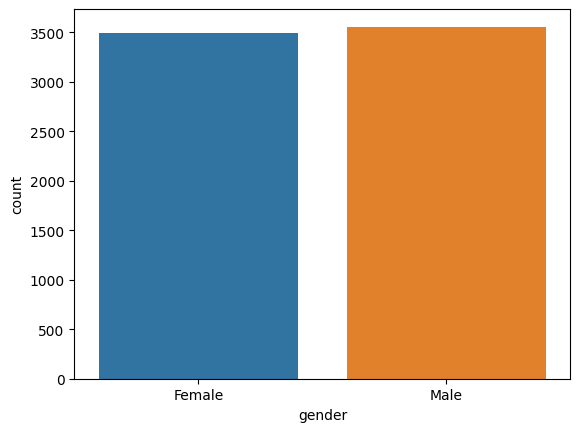

     Partner     Ratio
No      3641  0.516967
Yes     3402  0.483033
################################


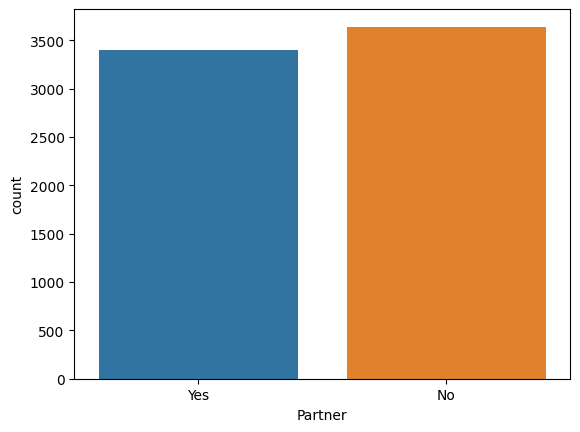

     Dependents     Ratio
No         4933  0.700412
Yes        2110  0.299588
################################


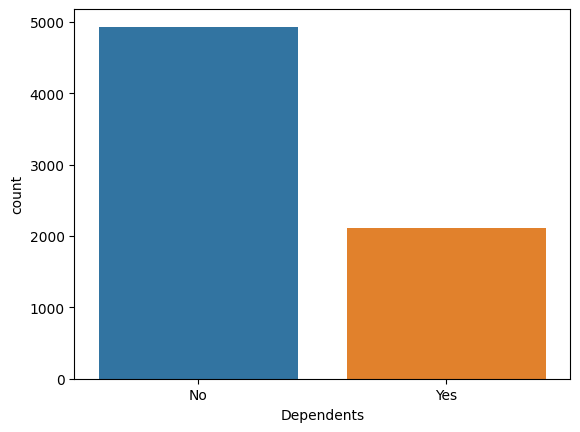

     PhoneService     Ratio
Yes          6361  0.903166
No            682  0.096834
################################


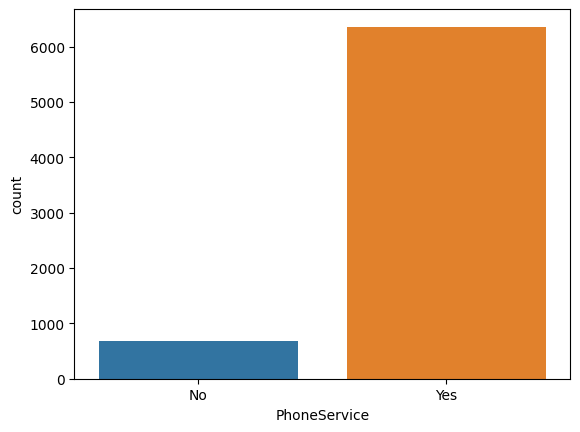

                  MultipleLines     Ratio
No                         3390  0.481329
Yes                        2971  0.421837
No phone service            682  0.096834
################################


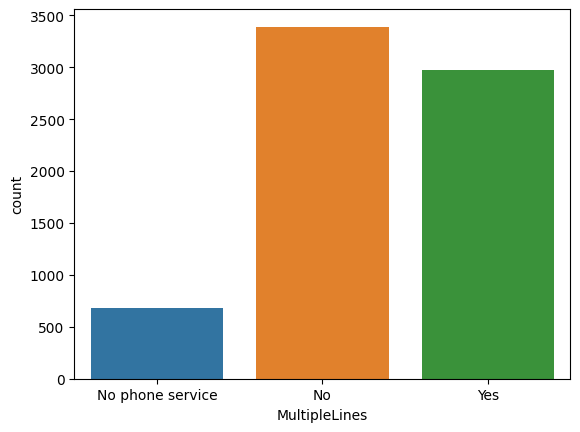

             InternetService     Ratio
Fiber optic             3096  0.439585
DSL                     2421  0.343746
No                      1526  0.216669
################################


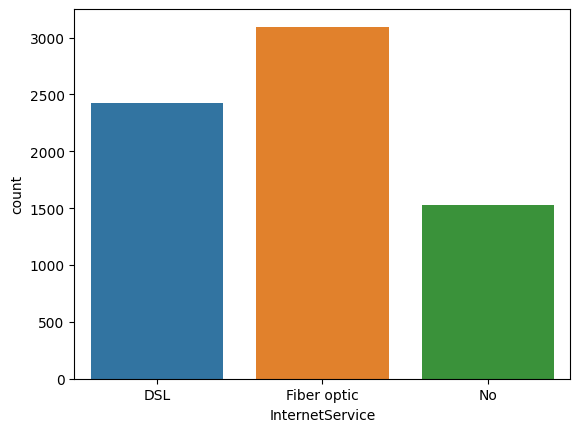

                     OnlineSecurity     Ratio
No                             3498  0.496663
Yes                            2019  0.286668
No internet service            1526  0.216669
################################


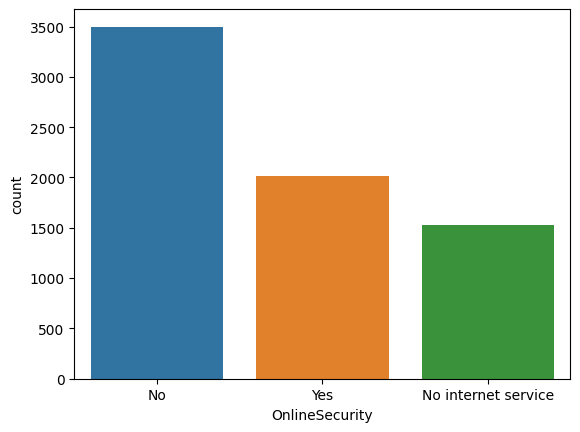

                     OnlineBackup     Ratio
No                           3088  0.438450
Yes                          2429  0.344881
No internet service          1526  0.216669
################################


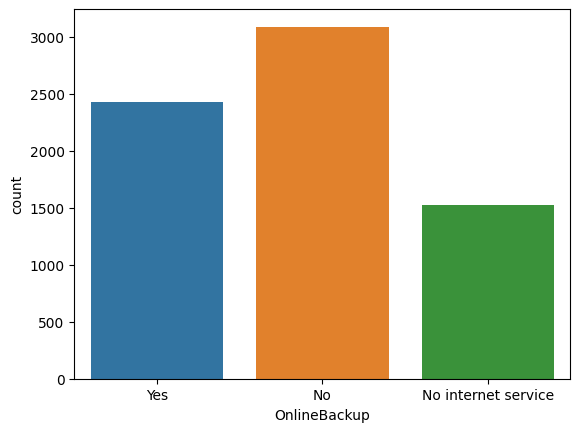

                     DeviceProtection     Ratio
No                               3095  0.439443
Yes                              2422  0.343888
No internet service              1526  0.216669
################################


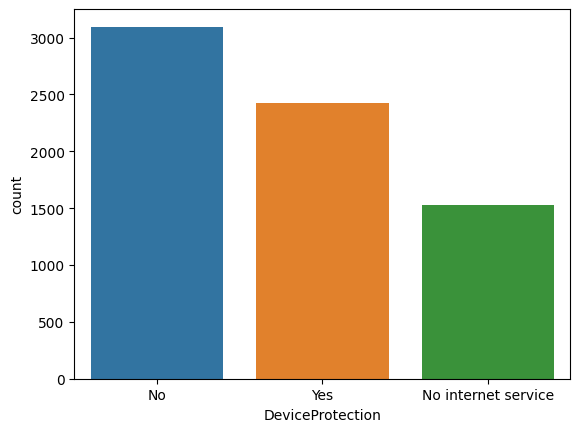

                     TechSupport     Ratio
No                          3473  0.493114
Yes                         2044  0.290217
No internet service         1526  0.216669
################################


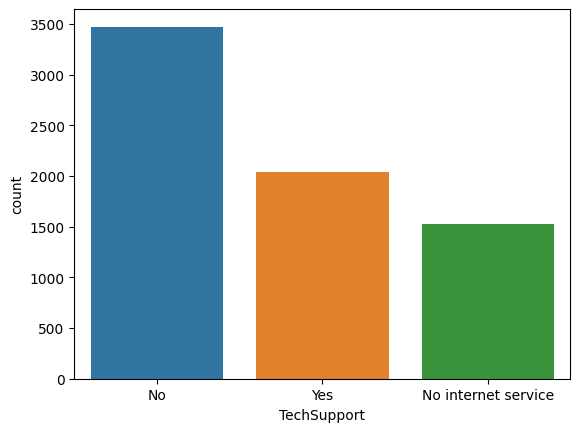

                     StreamingTV     Ratio
No                          2810  0.398978
Yes                         2707  0.384353
No internet service         1526  0.216669
################################


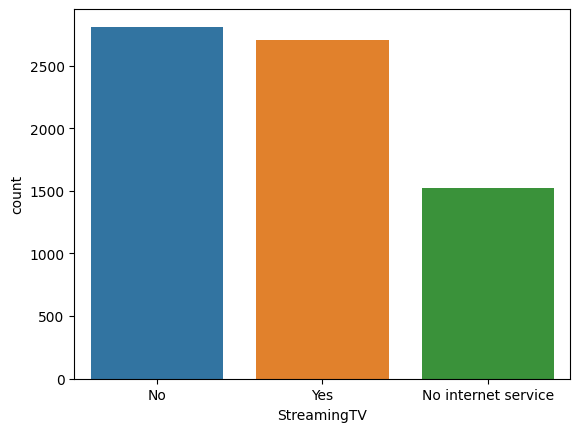

                     StreamingMovies     Ratio
No                              2785  0.395428
Yes                             2732  0.387903
No internet service             1526  0.216669
################################


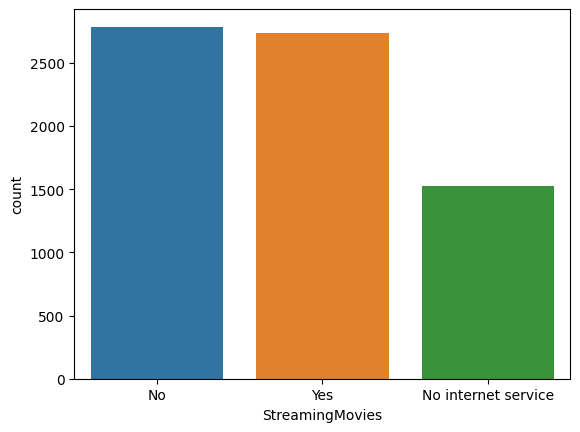

                Contract     Ratio
Month-to-month      3875  0.550192
Two year            1695  0.240664
One year            1473  0.209144
################################


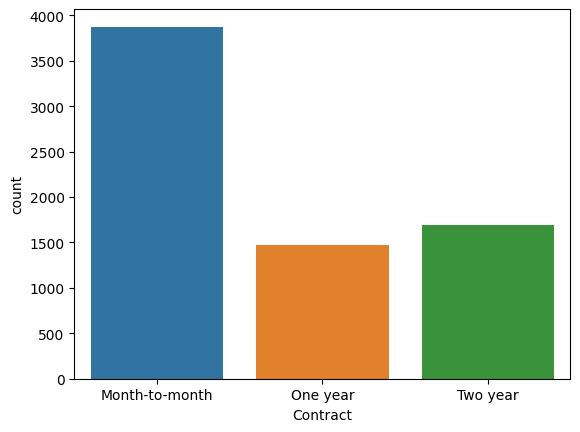

     PaperlessBilling     Ratio
Yes              4171  0.592219
No               2872  0.407781
################################


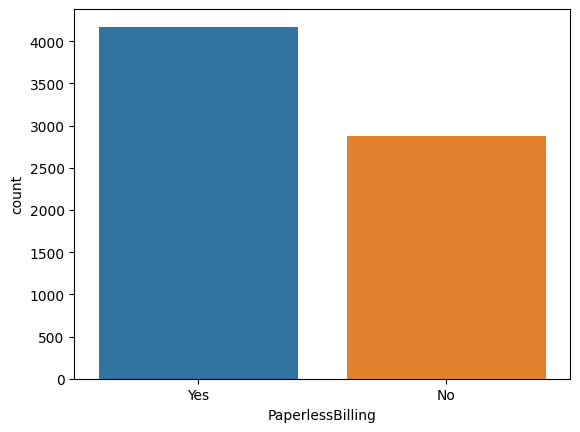

                           PaymentMethod     Ratio
Electronic check                    2365  0.335794
Mailed check                        1612  0.228880
Bank transfer (automatic)           1544  0.219225
Credit card (automatic)             1522  0.216101
################################


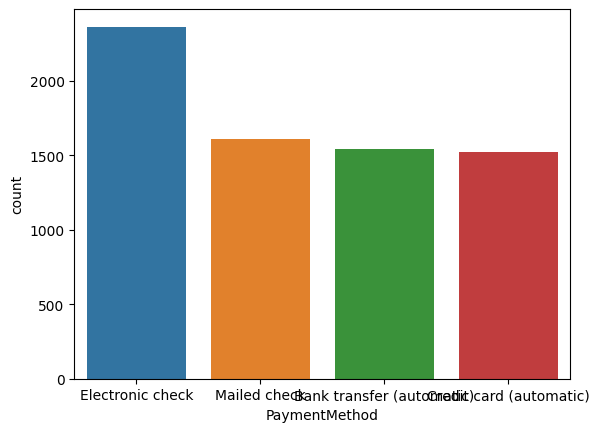

     Churn    Ratio
No    5174  0.73463
Yes   1869  0.26537
################################


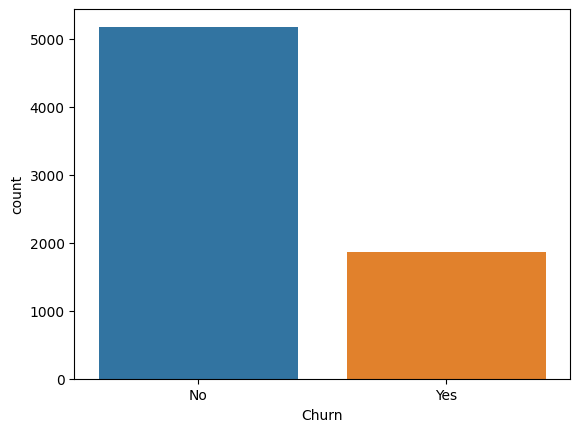

   SeniorCitizen     Ratio
0           5901  0.837853
1           1142  0.162147
################################


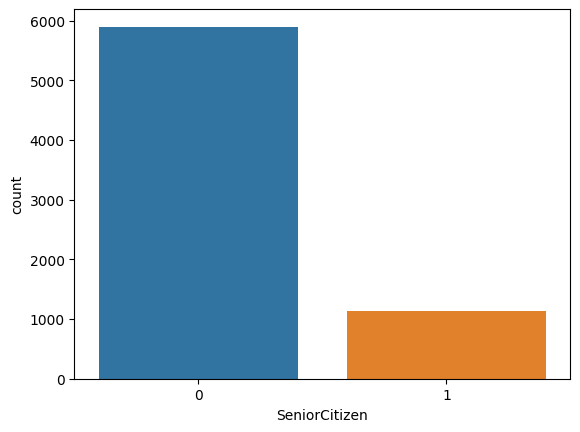

In [21]:
for col in cat_cols:
    cat_summary(df, col, plot = True)

In [22]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


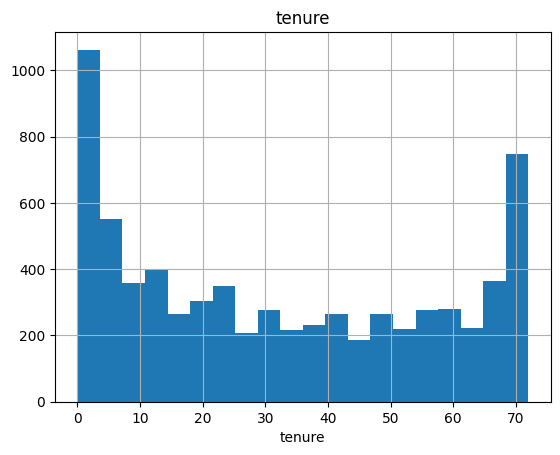

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


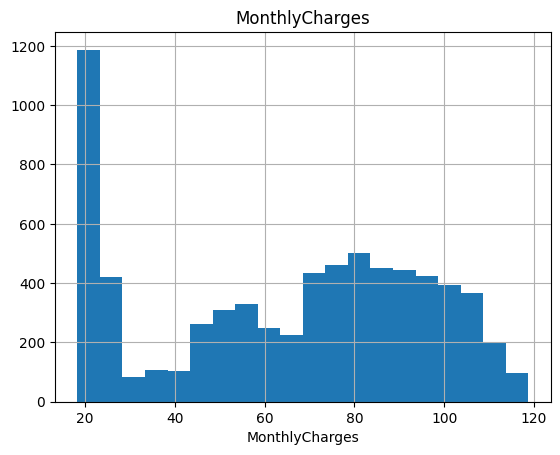

In [23]:
for col in num_cols:
    num_summary(df, col, plot = True)

In [24]:
def target_summary_with_num(dataframe, target, num_col):
    print(dataframe.groupby(target)[num_col].agg('mean'))
    

In [25]:
for col in num_cols:
    target_summary_with_num(df, 'Churn', col)

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64
Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64


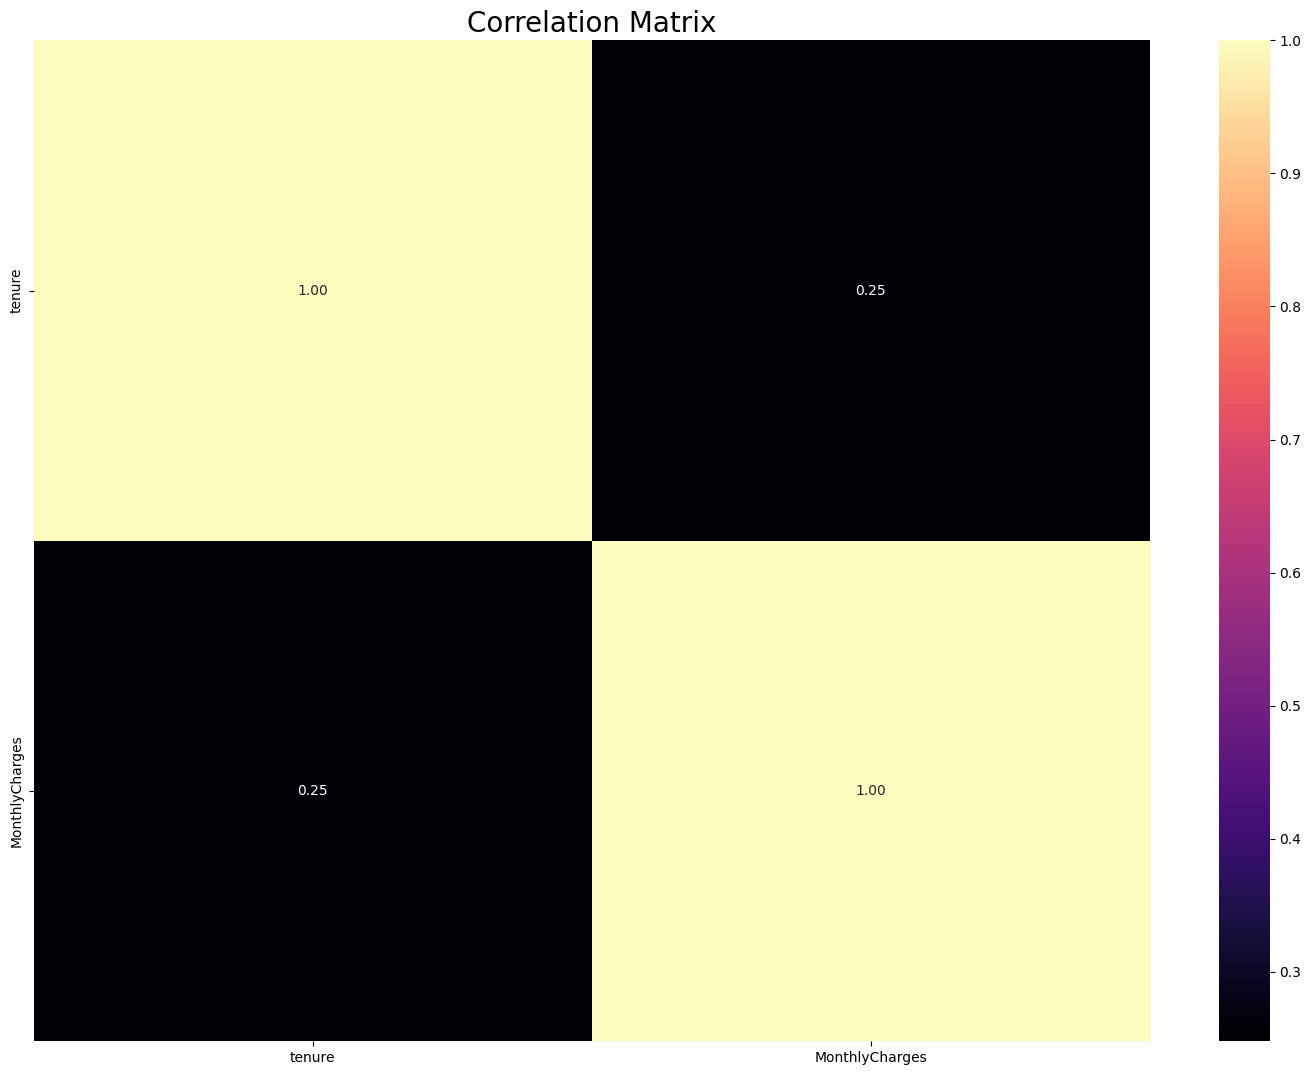

In [26]:
df[num_cols].corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show(block=True)

In [27]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [28]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isna().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum()/dataframe.shape[0])
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

df[df["TotalCharges"].isnull()]["tenure"]
df["TotalCharges"].fillna(0, inplace=True)

df.isnull().sum()

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [29]:
dff = df.copy()
cat_cols = [col for col in cat_cols if col not in ['Churn']]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [30]:
########## BASE MODEL ##########
def one_hot_encode(dataframe,categorical_cols,drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [31]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score

In [32]:
dff = one_hot_encode(dff, cat_cols, drop_first=True)


y = dff["Churn"]
X = dff.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)


In [36]:

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test, pos_label = 'Yes'),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test, pos_label = 'Yes'), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test, pos_label = 'Yes'), 4)}")

Accuracy: 0.7922
Recall: 0.6517
Precision: 0.5052
F1: 0.5692


In [37]:
from sklearn.model_selection import GridSearchCV, cross_validate

In [44]:
catboost_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': ['No', 'Yes'],
 'random_seed': 12345,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate':

In [45]:
cat_boost_params = {'iterations' : [500, 1000, 1500],
                    'model_size_reg' : [0.5, 0.6, 0.7],
                    'depth' : [6, 7, 8, 9, 10]}

In [49]:
cat_boost_best_params = GridSearchCV(catboost_model, cat_boost_params, cv=5, n_jobs = -1, verbose= True).fit(X,y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


KeyboardInterrupt: 

In [ ]:
cat_boost_best_params.best_params_

In [ ]:
cat_boost_finall = catboost_model.set_params(**cat_boost_best_params.best_params_).fit(X,y)

In [ ]:
cat_boost_final = cross_validate(cat_boost_finall, X, y, cv = 5, scoring = ['accuracy','f1','roc_auc'])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerID              7043 non-null   object 
 1   gender                  7043 non-null   object 
 2   SeniorCitizen           7043 non-null   int64  
 3   Partner                 7043 non-null   object 
 4   Dependents              7043 non-null   object 
 5   tenure                  7043 non-null   int64  
 6   PhoneService            7043 non-null   object 
 7   MultipleLines           7043 non-null   object 
 8   InternetService         7043 non-null   object 
 9   OnlineSecurity          7043 non-null   object 
 10  OnlineBackup            7043 non-null   object 
 11  DeviceProtection        7043 non-null   object 
 12  TechSupport             7043 non-null   object 
 13  StreamingTV             7043 non-null   object 
 14  StreamingMovies         7043 non-null   

In [70]:
df['TotalCharges'] = df['TotalCharges'].apply(lambda col: NaN if col == '' else col)


In [79]:
df = df.drop(columns = 'TotalCharges')

In [81]:
##################################
# ÖZELLİK ÇIKARIMI
##################################

# Tenure  değişkeninden yıllık kategorik değişken oluşturma
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"


# Kontratı 1 veya 2 yıllık müşterileri Engaged olarak belirtme
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

# Herhangi bir destek, yedek veya koruma almayan kişiler
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

# Aylık sözleşmesi bulunan ve genç olan müşteriler
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)


# Kişinin toplam aldığı servis sayısı
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)


# Herhangi bir streaming hizmeti alan kişiler
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Kişi otomatik ödeme yapıyor mu?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)



# Servis başına ücret
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)


In [87]:
from sklearn.preprocessing import LabelEncoder

In [88]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    df = label_encoder(df, col)

# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

Observations: 7043
Variables: 28
cat_cols: 24
num_cols: 3
cat_but_car: 1
num_but_cat: 7


,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,NEW_TotalServices,...,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,1,0,1,29.85,0,1,...,0,0,0,0,0,0,1,1,0,0
1,5575-GNVDE,1,0,0,34,1,0,56.95,0,3,...,1,0,0,0,0,1,1,0,0,0
2,3668-QPYBK,1,0,0,2,1,1,53.85,1,3,...,0,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,45,0,0,42.30,0,3,...,0,1,0,0,0,1,1,0,0,1
4,9237-HQITU,0,0,0,2,1,1,70.70,1,1,...,0,0,0,0,0,0,1,1,0,0


In [89]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [94]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test, pos_label = 1),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test, pos_label = 1), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test, pos_label = 1), 4)}")

Accuracy: 0.7956
Recall: 0.655
Precision: 0.5226
F1: 0.5814


        Value                                Feature
3   16.692418                                 tenure
6   12.870384                         MonthlyCharges
8   11.224945                    NEW_AVG_Service_Fee
36   5.769724                          NEW_Engaged_1
5    4.392719                       PaperlessBilling
26   4.007636                      Contract_Two year
0    2.886935                                 gender
28   2.482395         PaymentMethod_Electronic check
7    2.436942                      NEW_TotalServices
2    2.307638                             Dependents
1    2.283165                                Partner
18   2.178979                   DeviceProtection_Yes
11   2.050925            InternetService_Fiber optic
10   1.994386                      MultipleLines_Yes
34   1.882824               NEW_TENURE_YEAR_5-6 Year
35   1.818190                        SeniorCitizen_1
20   1.731811                        TechSupport_Yes
25   1.695345                      Contract_On

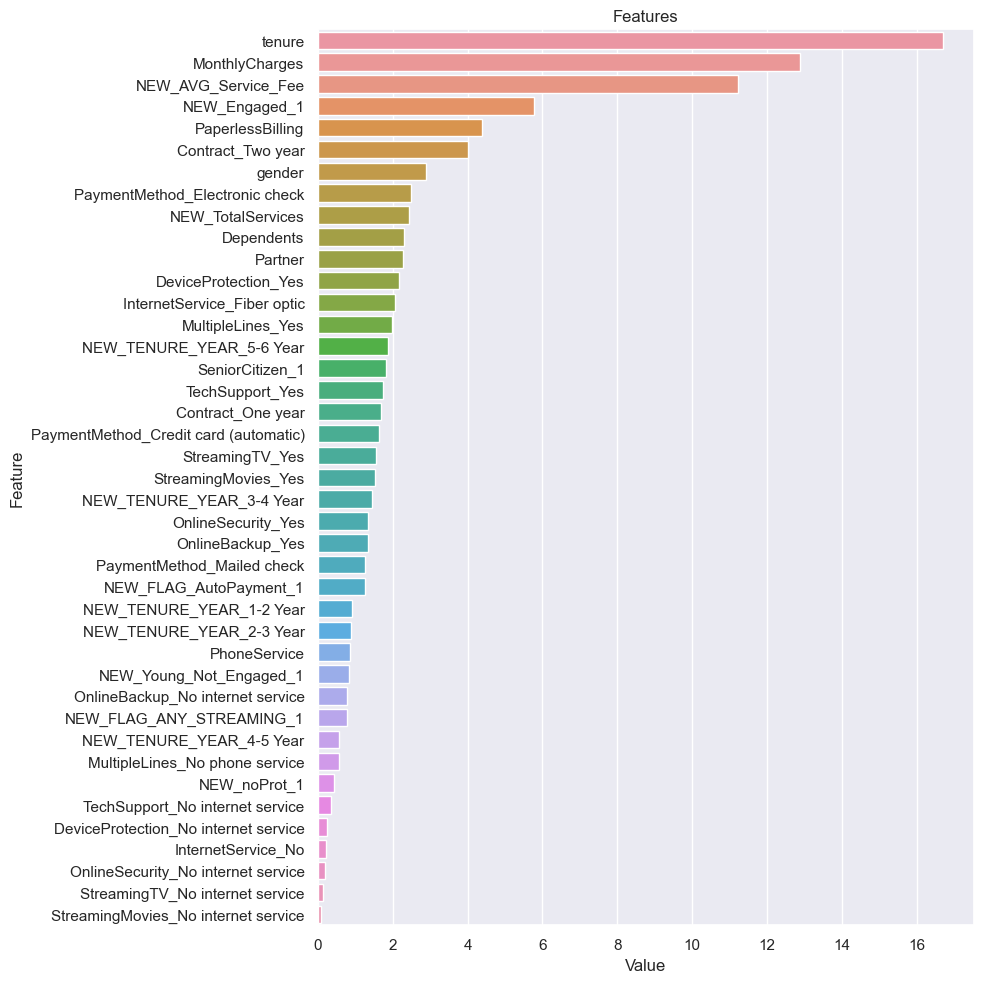

In [95]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_model, X)